# **This Code Is  Same as the code in MAX_CLIQUE but with the log technique**

In [1]:
!pip install dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 kB 19.2 MB/s eta 0:00:00


In [20]:
import numpy as np
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

def get_hamiltonian_terms(N, edges, A, B, C):
    Q = {}
    M = int(np.floor(np.log2(N)))
    # H_A terms


    for i in range(0, M):
        Q[(f'y_{i}', f'y_{i}')] = A * (2**i)
        for j in range(i + 1, M):
            Q[(f'y_{i}', f'y_{j}')] = 2 * A * (2**(i+j))


    Q[(f'y_{M}', f'y_{M}')] = A * (N + 1 - 2**M)**2


    for i in range(0, M):
      Q[(f'y_{i}', f'y_{M}')] = A * (2**i) * 2 * (N+1-2**M)


    for v in range(N):
        Q[(f'x_{v}', f'x_{v}')] = A
        for u in range(v+1,N):
          Q[(f'x_{v}', f'x_{u}')] =  -2 * A
        for i in range(0, M):
            Q[(f'y_{i}', f'x_{v}')] = - A * 2**i


    for v in range(0, N):
          Q[(f'y_{M}', f'x_{v}')] = - A * 2 * (N+1-2**M)

    # H_B terms
    for u, v in edges:
        Q[(f'x_{u}', f'x_{v}')] = - 2 * B
    for i in range(0, M):
        Q[(f'y_{i}', f'y_{i}')] += B * (2**(2*i)-2**i)/2
        for j in range(i + 1, M):
            Q[(f'y_{i}', f'y_{j}')] += B * (2**(i+j))
    for v in range(0, M):
          Q[(f'y_{v}', f'y_{M}')] += - A * 2 * (N+1-2**M) * (2**v)
    Q[(f'y_{M}', f'y_{M}')] += B * ((N + 1 - 2**M)**2 - (N + 1 - 2**M))

    # H_C terms
    for v in range(N):
        Q[(f'x_{v}', f'x_{v}')] -= C

    return Q

In [9]:
#Using Dwave Quantum Computer to solve the QUBO problem
token = 'DEV-abdc4c7339474eacea7a99b9e4269e22f667d3f2'
solver = 'Advantage_system6.4'

In [10]:
def find_largest_clique(graph, A, B, C):
    N = len(graph)
    edges = [(i, j) for i in range(N) for j in range(i + 1, N) if graph[i][j] == 1]

    # Get the QUBO terms
    Q = get_hamiltonian_terms(N, edges, A, B, C)
    print(Q)
    # Create a binary quadratic model
    bqm = BinaryQuadraticModel.from_qubo(Q)
    print(bqm)
    # Use D-Wave's quantum annealer
    sampler = EmbeddingComposite(DWaveSampler(token= token, solver = solver))
    sampleset = sampler.sample(bqm, num_reads=100)
    # print(sampleset)

    # Extract the best solution
    best_sample = sampleset.first.sample
    print(best_sample)
    largest_clique = [int(key.split('_')[1]) for key, value in best_sample.items() if key.startswith('x') and value == 1]

    return largest_clique, best_sample

In [21]:

# Example graph (adjacency matrix)
graph = [
    [0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 1, 1],
    [0, 1, 1, 0, 1],
    [0, 0, 1, 1, 0]
]

# Constants
A = 18
B = 2
C = 2

# Find the largest clique
largest_clique, best_sample = find_largest_clique(graph, A, B, C)
print("Largest Clique:", largest_clique)
print("Sample:", best_sample)

{('y_0', 'y_0'): 18.0, ('y_0', 'y_1'): 76, ('y_1', 'y_1'): 38.0, ('y_2', 'y_2'): 76, ('y_0', 'y_2'): 0, ('y_1', 'y_2'): 0, ('x_0', 'x_0'): 16, ('x_0', 'x_1'): -4, ('x_0', 'x_2'): -4, ('x_0', 'x_3'): -36, ('x_0', 'x_4'): -36, ('y_0', 'x_0'): -18, ('y_1', 'x_0'): -36, ('x_1', 'x_1'): 16, ('x_1', 'x_2'): -4, ('x_1', 'x_3'): -4, ('x_1', 'x_4'): -36, ('y_0', 'x_1'): -18, ('y_1', 'x_1'): -36, ('x_2', 'x_2'): 16, ('x_2', 'x_3'): -4, ('x_2', 'x_4'): -4, ('y_0', 'x_2'): -18, ('y_1', 'x_2'): -36, ('x_3', 'x_3'): 16, ('x_3', 'x_4'): -4, ('y_0', 'x_3'): -18, ('y_1', 'x_3'): -36, ('x_4', 'x_4'): 16, ('y_0', 'x_4'): -18, ('y_1', 'x_4'): -36, ('y_2', 'x_0'): -72, ('y_2', 'x_1'): -72, ('y_2', 'x_2'): -72, ('y_2', 'x_3'): -72, ('y_2', 'x_4'): -72}
BinaryQuadraticModel({'y_0': 18.0, 'y_1': 38.0, 'y_2': 76.0, 'x_0': 16.0, 'x_1': 16.0, 'x_2': 16.0, 'x_3': 16.0, 'x_4': 16.0}, {('y_1', 'y_0'): 76.0, ('y_2', 'y_0'): 0.0, ('y_2', 'y_1'): 0.0, ('x_0', 'y_0'): -18.0, ('x_0', 'y_1'): -36.0, ('x_0', 'y_2'): -72.0

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

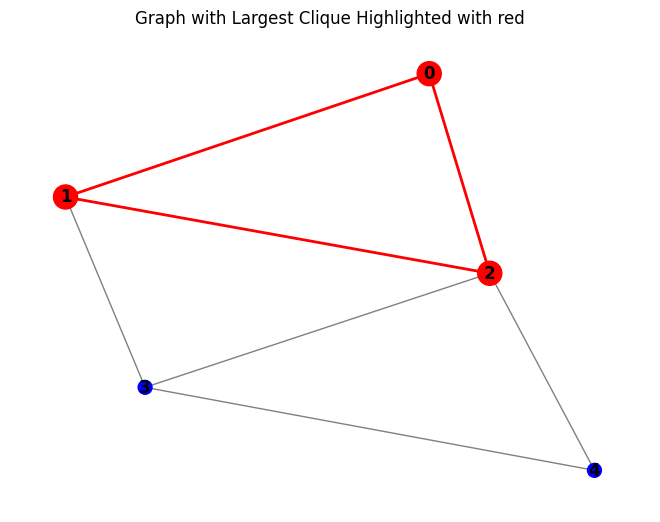

In [5]:
def plot_graph_with_clique(graph, largest_clique):
    G = nx.Graph()
    N = len(graph)

    # Add nodes
    for i in range(N):
        G.add_node(i)

    # Add edges
    for i in range(N):
        for j in range(i + 1, N):
            if graph[i][j] == 1:
                G.add_edge(i, j)

    # Set colors: red for clique nodes, blue for others
    node_colors = ['red' if node in largest_clique else 'blue' for node in G.nodes()]

    # Set sizes: larger size for clique nodes
    node_sizes = [300 if node in largest_clique else 100 for node in G.nodes()]

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', font_weight='bold')

    # Highlight the largest clique with a different color for edges
    clique_edges = [(i, j) for i in largest_clique for j in largest_clique if i < j and graph[i][j] == 1]
    nx.draw_networkx_edges(G, pos, edgelist=clique_edges, edge_color='red', width=2)

    plt.title("Graph with Largest Clique Highlighted with red")
    plt.show()

# Plot the graph with the largest clique highlighted
plot_graph_with_clique(graph, largest_clique)
